In [1]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.preprocessing import binarize
import pickle
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from mapseq_fxns import sort_by_celltype
# from math import log10
from scipy import stats

# random sample consimment between runs
import random

# import multiple t-tests
from statsmodels.sandbox.stats.multicomp import multipletests

# match edge color to facecolor
import matplotlib.patches

%matplotlib inline

In [2]:
# set-up variables
in_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/'
out_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/output/'

# import metadata
from M194_M220_metadata import *

# import colormaps
from colormaps import purple_cmp, green_cmp, blue_cmp, orange_cmp

#### load data
with open(in_path +'M194_M220_OMC_bin4.pkl', 'rb') as f:
    omc_bin = pickle.load(f)

In [3]:
# seperate by cell type

omc_type = [sort_by_celltype(omc_bin[i]) for i in range(num_samples)]
omc_pt = [(omc_type[i][omc_type[i]['type']==1000]).drop(["type"], axis=1).reset_index(drop=True) for i in range(num_samples)]
omc_it = [(omc_type[i][omc_type[i]['type']==10]).drop(["type"], axis=1).reset_index(drop=True) for i in range(num_samples)]

omc_mm = []
omc_st = []
omc_pt_mm = []
omc_pt_st = []
omc_it_mm = []
omc_it_st = []
mice_mm=[]
mice_st=[]

for i in range(num_samples):
    if metadata.species[i] == 'Mmus':
        omc_mm.append(omc_type[i])
        omc_pt_mm.append(omc_pt[i])
        omc_it_mm.append(omc_it[i])
        mice_mm.append(mice[i])
    else:
        omc_st.append(omc_type[i])
        omc_pt_st.append(omc_pt[i])
        omc_it_st.append(omc_it[i])
        mice_st.append(mice[i])

omc_mm_all = pd.concat(omc_mm)
omc_st_all = pd.concat(omc_st)

In [4]:
def clean_up_data(df_dirty):
    # drop unused areas
    to_drop = ['OB', 'ACAi', 'ACAc', 'HIP']
    dropped = df_dirty.drop(to_drop, axis=1)

    # change RN to bs
    replaced = dropped.rename(columns={'RN':'BS'})

    return replaced


In [5]:
for i in range(len(omc_it_mm)):
    omc_it_mm[i] = clean_up_data(omc_it_mm[i])

for i in range(len(omc_pt_mm)):
    omc_pt_mm[i] = clean_up_data(omc_pt_mm[i])

for i in range(len(omc_it_st)):
    omc_it_st[i] = clean_up_data(omc_it_st[i])

for i in range(len(omc_pt_st)):
    omc_pt_st[i] = clean_up_data(omc_pt_st[i])

# Node degree by cell type

In [6]:
def df_to_nodes(df_list, drop = ["OMCi", "type"], mice=None, species=None):
    """
    Function to turn list of binarized dataframes per animal to dataframe 
    containing node proportions

    df_list = list of binarized dataframes
    drop = list of column names to drop
    mice = list of mouse names
    species = string of species name
    returns dataframe of node proportions
    """

    nodes_list = []
    for i in range(len(df_list)):
        if drop == []:
            int_df = df_list[i]
        else:
            int_df = df_list[i].drop(drop, axis=1)
        nodes = int_df.sum(axis=1)
        node_counts = nodes.value_counts().sort_index()
        node_proportion = node_counts/node_counts.sum()
        df_save = pd.DataFrame(node_proportion, columns=["Normalized Frequency"]).reset_index(names="Node Degree")
        df_save["Species"] = species
        df_save["mouse"] = mice[i]
        nodes_list.append(df_save)

    node_all = pd.concat(nodes_list)

    return node_all


In [7]:
mm_it_nodes = df_to_nodes(omc_it_mm, drop=["OMCi"], mice=mice_mm, species="MMus")
st_it_nodes = df_to_nodes(omc_it_st, drop=["OMCi"], mice=mice_st, species="STeg")
mm_pt_nodes = df_to_nodes(omc_pt_mm, drop=["OMCi"], mice=mice_mm, species="MMus")
st_pt_nodes = df_to_nodes(omc_pt_st, drop=["OMCi"], mice=mice_st, species="STeg")

# Plotting by node!


In [39]:
def dot_bar_plot(df, title):
    """
    Function to take pandas dataframe and plot individual values and mean/sem values
    Intent to use for plotting nodes by frequency (in fraction of neurons)

    Args:
        df (pandas.core.frame.DataFrame): pandas dataframe where rows are nodes and columns are:
         'Node Degreee', 'Normalized Frequency', 'Species', and 'mouse'
         - See output of df_to_nodes
        title (str): plot title
    """
    sns.stripplot(df, x="Node Degree", y="Normalized Frequency", hue="Species", dodge=True, jitter=False, size=3)
    t_ax = sns.barplot(df, x="Node Degree", y="Normalized Frequency", hue="Species", errorbar="se", errwidth=1)
    for patch in t_ax.patches:
        clr = patch.get_facecolor()
        patch.set_edgecolor(clr)
        patch.set_facecolor((0,0,0,0))
    plt.setp(t_ax.patches, linewidth=1)
    plt.title(title, size=18)

    return(plt.show())
    

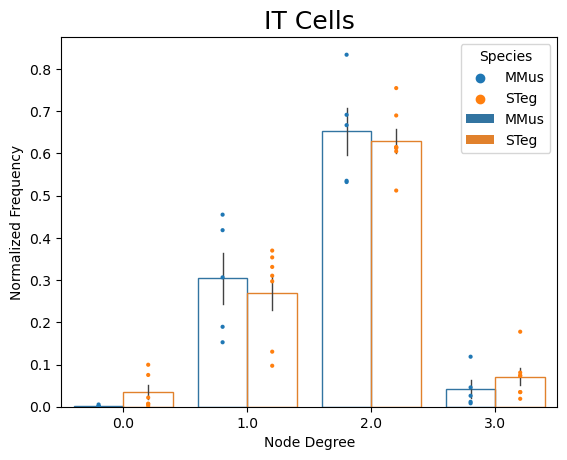

In [40]:
plot = pd.concat([mm_it_nodes, st_it_nodes])
dot_bar_plot(plot, "IT Cells")

In [86]:
# change node 6 to 6+
idx5 = mm_pt_nodes['Node Degree'] > 5
mm_pt_nodes_5and = mm_pt_nodes[~idx5].reset_index(drop=True)
for i in range(len(mice_mm)):
    idxm = mm_pt_nodes[idx5]['mouse'] == mice_mm[i]
    int = mm_pt_nodes[idx5][idxm]
    int_sum = int['Normalized Frequency'].sum()
    mm_pt_nodes_5and.loc[len(mm_pt_nodes_5and.index)] = ['6+', int_sum, 'MMus', mice_mm[i]]
# mm_pt_nodes_5and

In [84]:
# change node 6 to 6+
idx5 = st_pt_nodes['Node Degree'] > 5
st_pt_nodes_5and = st_pt_nodes[~idx5].reset_index(drop=True)
for i in range(len(mice_st)):
    idxm = st_pt_nodes[idx5]['mouse'] == mice_st[i]
    int = st_pt_nodes[idx5][idxm]
    int_sum = int['Normalized Frequency'].sum()
    st_pt_nodes_5and.loc[len(st_pt_nodes_5and.index)] = ['6+', int_sum, 'STeg', mice_st[i]]
st_pt_nodes_5and

,Node Degree,Normalized Frequency,Species,mouse
0,1.0,0.012346,STeg,STM1
1,2.0,0.086420,STeg,STM1
2,3.0,0.172840,STeg,STM1
3,4.0,0.259259,STeg,STM1
4,5.0,0.222222,STeg,STM1
5,1.0,0.030303,STeg,STM2
6,2.0,0.121212,STeg,STM2
7,3.0,0.151515,STeg,STM2
8,4.0,0.363636,STeg,STM2
9,5.0,0.212121,STeg,STM2


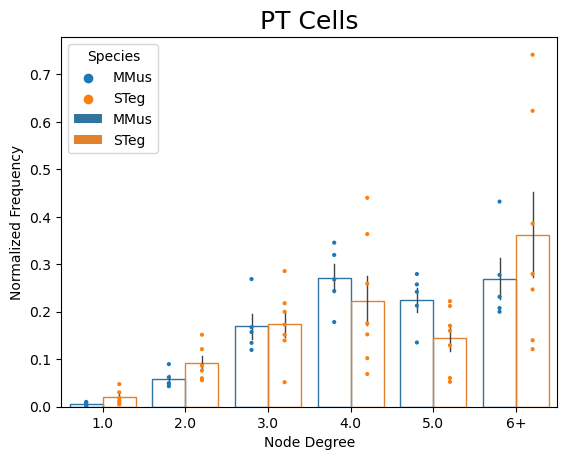

In [85]:
plot = pd.concat([mm_pt_nodes_5and, st_pt_nodes_5and])
dot_bar_plot(plot, "PT Cells")

# Look at AUD neurons

In [42]:
# seperate AUD neurons

aud_it_mm = []
for i in range(len(omc_it_mm)):
    aud_idx = omc_it_mm[i]["AUD"] == 1
    aud_it_mm.append(omc_it_mm[i][aud_idx])

aud_it_st = []
for i in range(len(omc_it_st)):
    aud_idx = omc_it_st[i]["AUD"] == 1
    aud_it_st.append(omc_it_st[i][aud_idx])

aud_pt_mm = []
for i in range(len(omc_pt_mm)):
    aud_idx = omc_pt_mm[i]["AUD"] == 1
    aud_pt_mm.append(omc_pt_mm[i][aud_idx])

aud_pt_st = []
for i in range(len(omc_pt_st)):
    aud_idx = omc_pt_st[i]["AUD"] == 1
    aud_pt_st.append(omc_pt_st[i][aud_idx])

In [43]:
# calculate degrees for aud cells
aud_mm_it_nodes = df_to_nodes(aud_it_mm, drop=["OMCi"], mice=mice_mm, species="MMus")
aud_st_it_nodes = df_to_nodes(aud_it_st, drop=["OMCi"], mice=mice_st, species="STeg")
aud_mm_pt_nodes = df_to_nodes(aud_pt_mm, drop=["OMCi"], mice=mice_mm, species="MMus")
aud_st_pt_nodes = df_to_nodes(aud_pt_st, drop=["OMCi"], mice=mice_st, species="STeg")

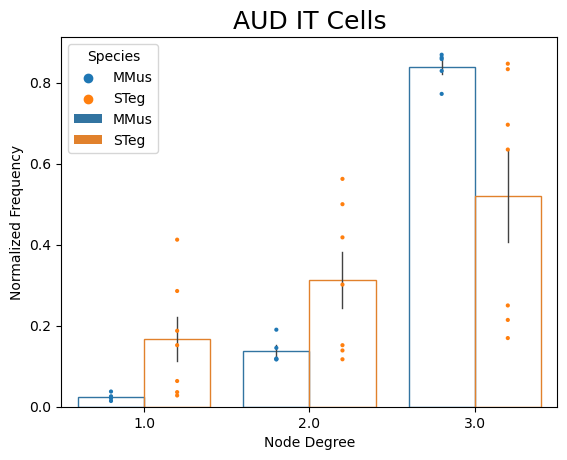

In [44]:
plot = pd.concat([aud_mm_it_nodes, aud_st_it_nodes])
dot_bar_plot(plot, "AUD IT Cells")

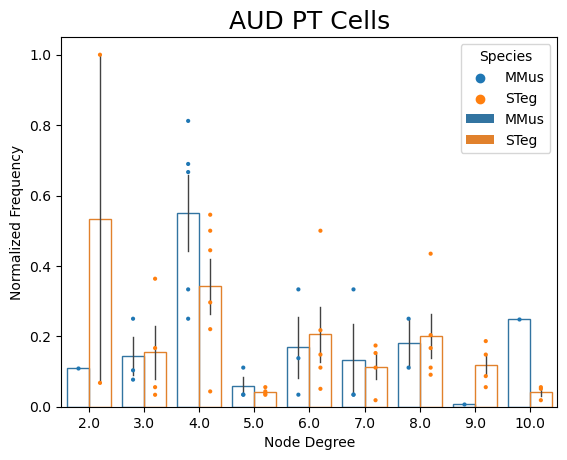

In [45]:
plot = pd.concat([aud_mm_pt_nodes, aud_st_pt_nodes])
dot_bar_plot(plot, "AUD PT Cells")

Text(0.5, 1.0, 'AUD PT Cells')

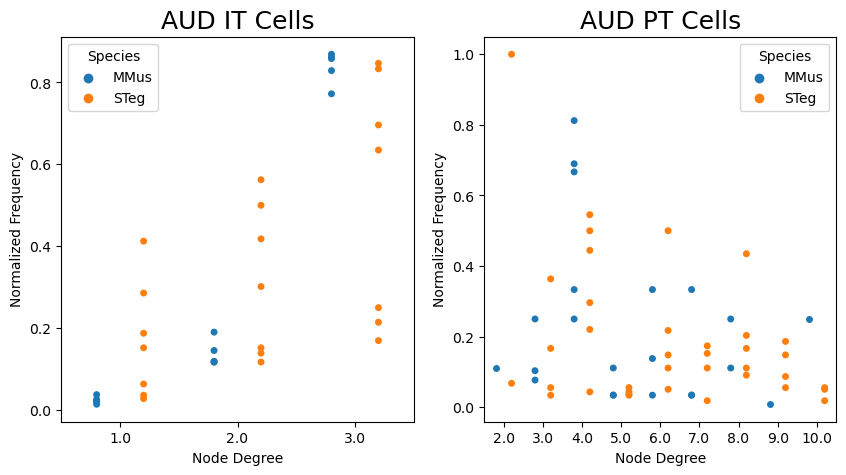

In [31]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

# make dot plots for degrees
plot = pd.concat([aud_mm_it_nodes, aud_st_it_nodes])
sns.stripplot(plot, x="Node Degree", y="Normalized Frequency", hue="Species", dodge=True,
              jitter = False, ax=axs[0])
axs[0].set_title("AUD IT Cells", size=18)

# make dot plots for degrees
plot = pd.concat([aud_mm_pt_nodes, aud_st_pt_nodes])
sns.stripplot(plot, x="Node Degree", y="Normalized Frequency", hue="Species", dodge=True,
              jitter = False, ax=axs[1])
axs[1].set_title("AUD PT Cells", size=18)

Text(0.5, 1.0, 'AUD PT Cells')

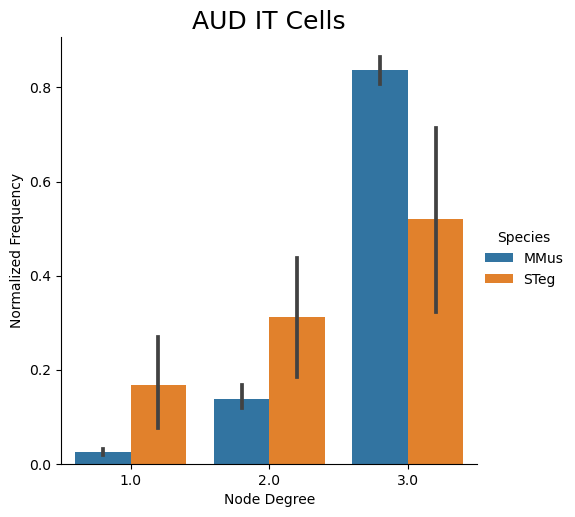

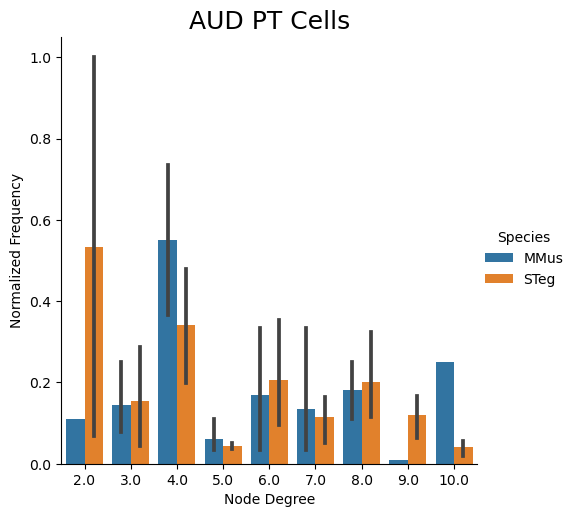

In [25]:
# make dot plots for degrees
plot = pd.concat([aud_mm_it_nodes, aud_st_it_nodes])
sns.catplot(plot, x="Node Degree", y="Normalized Frequency", hue="Species", kind="bar")
plt.title("AUD IT Cells", size=18)

# make dot plots for degrees
plot = pd.concat([aud_mm_pt_nodes, aud_st_pt_nodes])
sns.catplot(plot, x="Node Degree", y="Normalized Frequency", hue="Species", kind="bar")
plt.title("AUD PT Cells", size=18)

# probability testing

# expected: P(A) x P(B)


In [ ]:
def df_to_nodes(df_list, drop = ["OMCi", "type"], mice=None, species=None):
    """
    Function to turn list of binarized dataframes per animal to dataframe 
    containing node proportions

    df_list = list of binarized dataframes
    drop = list of column names to drop
    mice = list of mouse names
    species = string of species name
    returns dataframe of node proportions
    """

    nodes_list = []
    for i in range(len(df_list)):
        if drop == []:
            int_df = df_list[i]
        else:
            int_df = df_list[i].drop(drop, axis=1)
        nodes = int_df.sum(axis=1)
        node_counts = nodes.value_counts().sort_index()
        node_proportion = node_counts/node_counts.sum()
        df_save = pd.DataFrame(node_proportion, columns=["Normalized Frequency"]).reset_index(names="Node Degree")
        df_save["Species"] = species
        df_save["mouse"] = mice[i]
        nodes_list.append(df_save)

    node_all = pd.concat(nodes_list)

    return node_all

In [ ]:
def calc_axb(df_list, mice=None, species=None):
    exp_list = []
    for i in range(len(df_list)):
        df = df_list[i]
        df_prob = df.sum()/df.shape[0]
        exp_list.append(df_prob)
    return exp_list



In [33]:
aud_it_mm[0].sum()

OMCi    117.0
OMCc    105.0
AUD     117.0
STR     106.0
TH        0.0
HY        0.0
AMY       0.0
SNr       0.0
SCm       0.0
PG        0.0
PAG       0.0
BS        0.0
dtype: float64